In [1]:
cd ../

/Users/rabitt/Dropbox/MARL/repos/motif


In [2]:
import motif
import os
import glob
import csv
import librosa
import numpy as np
import medleydb as mdb
import mir_eval
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tempfile as tmp
sns.set()
%matplotlib inline

/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
etr = motif.run.get_extract_module('hll')

In [4]:
def compute_contours_gt_seeds(etr, audio_filepath, seeds_fpath):
    tmp_audio = etr._preprocess_audio(
        audio_filepath, normalize_format=True, normalize_volume=True
    )

    contours_fpath = tmp.mktemp('.csv')

    args = [
        "hll",
        "{}".format(tmp_audio),
        "{}".format(seeds_fpath),
        "{}".format(contours_fpath),
        "{}".format(etr.n_harmonics),
        "{}".format(etr.f_cutoff),
        "{}".format(etr.tracking_gain),
        "{}".format(etr.min_contour_len_samples),
        "{}".format(etr.amplitude_threshold),
        "{}".format(etr.tracking_update_threshold)
    ]
    os.system(' '.join(args))

    if not os.path.exists(contours_fpath):
        raise IOError(
            "Unable to find HLL output file {}".format(contours_fpath)
        )

    c_numbers, c_times, c_freqs, c_sal = etr._load_contours(contours_fpath)

    os.remove(contours_fpath)
    os.remove(tmp_audio)

#     (c_numbers, c_times, c_freqs, c_sal) = etr._postprocess_contours(
#         c_numbers, c_times, c_freqs, c_sal
#     )

    return motif.core.Contours(
        c_numbers, c_times, c_freqs, c_sal, etr.sample_rate, audio_filepath
    )

In [5]:
mtracks = mdb.load_melody_multitracks()

In [6]:
AUDIO_PATH = '/Users/rabitt/Dropbox/MARL/mono/'
ANNOT_PATH = '/Users/rabitt/Dropbox/MARL/repos/medleydb/Annotations/'
SEED_PATH = '/Users/rabitt/Dropbox/mdb_seeds_mel3/'

file_pairs = []
for mtrack in mtracks:
    tid = mtrack.track_id
    audio_file = os.path.join(AUDIO_PATH, '{}_MIX.wav'.format(tid))
    annot_file = os.path.join(
        ANNOT_PATH, '{}_ANNOTATIONS'.format(tid), '{}_MELODY3.csv'.format(tid))
    seed_file = os.path.join(SEED_PATH, '{}_gt_seeds.csv'.format(tid))
    file_pairs.append((audio_file, annot_file, seed_file))

In [7]:
etr.hop_size = 256
etr.n_octaves = 6
etr.bins_per_octave = 12
etr.min_note = 'E1'
etr.peak_thresh = 0.3
etr.filter_scale = 2.0
etr.avg_filt_len = 12

# librosa peak pick params for seed detection
etr.pre_max = 8
etr.post_max = 8
etr.pre_avg = 1
etr.post_avg = 1
etr.delta = 0.2
etr.wait = 10

# HLL paramters
etr.n_harmonics = 5
etr.f_cutoff = 30  # Hz
etr.tracking_gain = 0.001
etr.min_contour_len_samples = int(round(etr.audio_samplerate / 20.0))
etr.amplitude_threshold = 0.001
etr.tracking_update_threshold = 100.0

In [14]:
k = 65
print(file_pairs[k])
ctr = compute_contours_gt_seeds(etr, file_pairs[k][0], file_pairs[k][2])

('/Users/rabitt/Dropbox/MARL/mono/MusicDelta_Country1_MIX.wav', '/Users/rabitt/Dropbox/MARL/repos/medleydb/Annotations/MusicDelta_Country1_ANNOTATIONS/MusicDelta_Country1_MELODY3.csv', '/Users/rabitt/Dropbox/mdb_seeds_mel3/MusicDelta_Country1_gt_seeds.csv')


(25, 32)

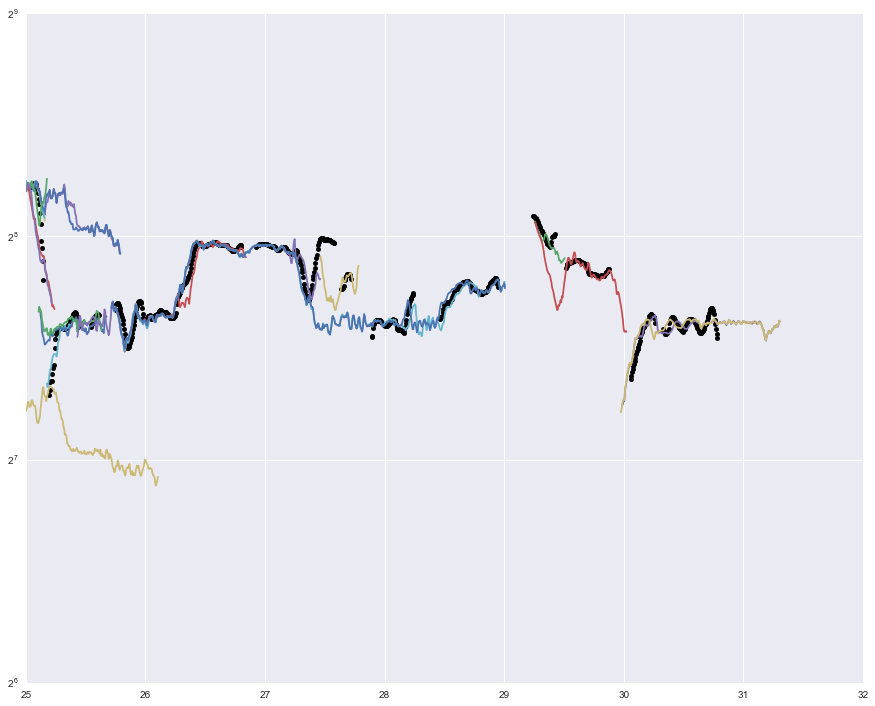

In [16]:
plt.figure(figsize=(15,12))
ctr.plot_with_annotation(file_pairs[k][1], single_f0=False)
plt.xlim([25, 32])

In [13]:
def load_melody3_multif0(fpath):
    times = []
    freqs = []
    with open(fpath, 'r') as fhandle:
        reader = csv.reader(fhandle, delimiter=',')
        for line in reader:
            times.append(float(line[0]))
            f = np.array(line[1:], dtype=float)
            f = f[f > 0]
            freqs.append(f)
    return np.array(times), freqs

In [63]:
hll_scores = {}
sal_scores = {}
hll_contours = {}
sal_contours = {}
etr_salamon = motif.run.get_extract_module('salamon')

for audio_fpath, annot_fpath, seed_fpath in file_pairs:
    tid = '_'.join(os.path.basename(audio_fpath).split('_')[:2])
    print(tid)

    # compute and score contours
    ctr_hll = compute_contours_gt_seeds(etr, audio_fpath, seed_fpath)
    ctr_sal = etr_salamon.compute_contours(audio_fpath)
    hll_contours[tid] = ctr_hll
    sal_contours[tid] = ctr_sal
    est_time_hll, est_freqs_hll = ctr_hll.to_multif0_format()
    est_time_sal, est_freqs_sal = ctr_sal.to_multif0_format()
    ref_time, ref_freqs = load_melody3_multif0(annot_fpath)
    scores_hll = mir_eval.multipitch.evaluate(
        np.array(ref_time), ref_freqs, np.array(est_time_hll), est_freqs_hll
    )
    scores_sal = mir_eval.multipitch.evaluate(
        np.array(ref_time), ref_freqs, np.array(est_time_sal), est_freqs_sal
    )
    hll_scores[tid] = scores_hll
    sal_scores[tid] = scores_sal

AClassicEducation_NightOwl
AimeeNorwich_Child
AimeeNorwich_Flying
AlexanderRoss_GoodbyeBolero
AlexanderRoss_VelvetCurtain
AmarLal_Rest
AmarLal_SpringDay1
Auctioneer_OurFutureFaces
AvaLuna_Waterduct
BigTroubles_Phantom
BrandonWebster_DontHearAThing
BrandonWebster_YesSirICanFly
CelestialShore_DieForUs
ChrisJacoby_BoothShotLincoln
ChrisJacoby_PigsFoot
ClaraBerryAndWooldog_AirTraffic
ClaraBerryAndWooldog_Boys
ClaraBerryAndWooldog_Stella
ClaraBerryAndWooldog_TheBadGuys
ClaraBerryAndWooldog_WaltzForMyVictims
Creepoid_OldTree
CroqueMadame_Oil
CroqueMadame_Pilot
Debussy_LenfantProdigue
DreamersOfTheGhetto_HeavyLove
EthanHein_1930sSynthAndUprightBass
EthanHein_GirlOnABridge
FacesOnFilm_WaitingForGa
FamilyBand_Again
Handel_TornamiAVagheggiar
HeladoNegro_MitadDelMundo
HezekiahJones_BorrowedHeart
HopAlong_SisterCities
InvisibleFamiliars_DisturbingWildlife
JoelHelander_Definition
JoelHelander_ExcessiveResistancetoChange
JoelHelander_IntheAtticBedroom
KarimDouaidy_Hopscotch
KarimDouaidy_Yatora
LizNe

In [64]:
df_hll = pd.DataFrame.from_dict(hll_scores, orient='index')
df_sal = pd.DataFrame.from_dict(sal_scores, orient='index')

In [65]:
df_hll.describe()

,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,Chroma Accuracy,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.330141,0.687394,0.281479,0.166916,0.145690,1.488922,1.801527,0.336609,0.700403,0.288788,0.153907,0.145690,1.488922,1.788518
std,0.106591,0.119572,0.081537,0.067807,0.103457,0.951794,0.927316,0.109193,0.120795,0.085272,0.063640,0.103457,0.951794,0.929332
min,0.100461,0.337422,0.097848,0.027248,0.005917,0.175772,0.688877,0.100567,0.337422,0.097962,0.027248,0.005917,0.175772,0.632604
25%,0.253943,0.612716,0.224899,0.130803,0.071342,0.902107,1.192848,0.263157,0.625112,0.235635,0.114479,0.071342,0.902107,1.166905
50%,0.326609,0.689863,0.284427,0.159346,0.127879,1.265227,1.595659,0.327929,0.703171,0.287687,0.148645,0.127879,1.265227,1.572524
75%,0.397803,0.781431,0.332488,0.202004,0.202178,1.958797,2.264474,0.401140,0.792037,0.337782,0.183540,0.202178,1.958797,2.219794
max,0.578468,0.942303,0.478556,0.358920,0.466351,6.919442,7.129393,0.606995,0.944948,0.577469,0.334063,0.466351,6.919442,7.128558


In [66]:
df_sal.describe()

,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,Chroma Accuracy,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.311947,0.585057,0.243481,0.288150,0.126793,1.453141,1.868084,0.359925,0.673535,0.288903,0.199671,0.126793,1.453141,1.779605
std,0.155190,0.191767,0.110281,0.154473,0.126311,1.167681,1.117389,0.162589,0.165329,0.108741,0.116638,0.126311,1.167681,1.102523
min,0.078311,0.113036,0.048505,0.002626,0.002936,0.000838,0.504453,0.121450,0.252834,0.104961,0.001713,0.002936,0.000838,0.503540
25%,0.196123,0.445762,0.168990,0.171898,0.030091,0.546983,0.999529,0.245884,0.557737,0.215036,0.116276,0.030091,0.546983,0.934438
50%,0.280800,0.570814,0.233446,0.270671,0.084674,1.088129,1.453015,0.318051,0.686533,0.270023,0.171893,0.084674,1.088129,1.362461
75%,0.418193,0.728207,0.303768,0.396646,0.180379,2.157531,2.476705,0.452430,0.804116,0.363913,0.269140,0.180379,2.157531,2.398995
max,0.756974,0.982416,0.659563,0.725857,0.601597,5.398256,5.636560,0.830042,0.983330,0.660581,0.625476,0.601597,5.398256,5.632031


(70, 100)

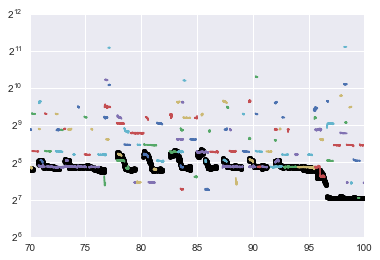

In [68]:
sal_contours['AClassicEducation_NightOwl'].plot_with_annotation(file_pairs[0][1], single_f0=False)
# plt.axis([25, 50, 100, 1000])
plt.xlim([70, 100])

In [81]:
all_scores_hpss = {}
contours = {}
track_id_list = [
    'MusicDelta_Country1', 'MusicDelta_Beatles', 'ClaraBerryAndWooldog_Boys',
    'MusicDelta_Rockabilly', 'Schubert_Erstarrung', 'AmarLal_SpringDay1',
    'LizNelson_ImComingHome'
]

for audio_fpath, annot_fpath, _ in file_pairs:
    tid = '_'.join(os.path.basename(audio_fpath).split('_')[:2])
    if tid in track_id_list:
        continue

    print(tid)
    y, fs = librosa.load(audio_fpath, sr=44100)
    y_harm = librosa.effects.harmonic(y)
    tmp_audio = tmp.mktemp('.wav')
    librosa.output.write_wav(tmp_audio, y_harm, fs)

    # compute and score contours
    ctr = etr.compute_contours(audio_fpath)
    contours[tid] = ctr
    est_time, est_freqs = ctr.to_multif0_format()
    ref_time, ref_freqs = load_melody3_multif0(annot_fpath)
    scores = mir_eval.multipitch.evaluate(
        np.array(ref_time), ref_freqs, np.array(est_time), est_freqs
    )
    all_scores_hpss[tid] = scores


AClassicEducation_NightOwl
AimeeNorwich_Child
AimeeNorwich_Flying
AlexanderRoss_GoodbyeBolero
AlexanderRoss_VelvetCurtain
AmarLal_Rest
Auctioneer_OurFutureFaces
AvaLuna_Waterduct
BigTroubles_Phantom
BrandonWebster_DontHearAThing
BrandonWebster_YesSirICanFly
CelestialShore_DieForUs
ChrisJacoby_BoothShotLincoln
ChrisJacoby_PigsFoot
ClaraBerryAndWooldog_AirTraffic
ClaraBerryAndWooldog_Stella
ClaraBerryAndWooldog_TheBadGuys
ClaraBerryAndWooldog_WaltzForMyVictims
Creepoid_OldTree
CroqueMadame_Oil
CroqueMadame_Pilot
Debussy_LenfantProdigue
DreamersOfTheGhetto_HeavyLove
EthanHein_1930sSynthAndUprightBass
EthanHein_GirlOnABridge
FacesOnFilm_WaitingForGa
FamilyBand_Again
Handel_TornamiAVagheggiar
HeladoNegro_MitadDelMundo
HezekiahJones_BorrowedHeart
HopAlong_SisterCities
InvisibleFamiliars_DisturbingWildlife
JoelHelander_Definition
JoelHelander_ExcessiveResistancetoChange
JoelHelander_IntheAtticBedroom
KarimDouaidy_Hopscotch
KarimDouaidy_Yatora
LizNelson_Coldwar
LizNelson_Rainfall
MatthewEntwis

In [82]:
df_hpss = pd.DataFrame.from_dict(all_scores_hpss, orient='index')

In [83]:
df_hpss.describe()

,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,Chroma Accuracy,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.044878,0.632058,0.041171,0.333149,0.034793,22.507683,22.875625,0.059508,0.808268,0.055487,0.156939,0.034793,22.507683,22.699416
std,0.040934,0.187518,0.030909,0.160850,0.077152,19.471465,19.386191,0.052903,0.148091,0.041340,0.102869,0.077152,19.471465,19.399111
min,0.005535,0.154894,0.005500,0.060894,0.000000,0.362969,1.208075,0.008167,0.247308,0.008137,0.014387,0.000000,0.362969,1.115661
25%,0.023002,0.495386,0.022648,0.222554,0.000000,9.032750,9.360139,0.029413,0.717941,0.029322,0.074008,0.000000,9.032750,9.236310
50%,0.034561,0.659928,0.033767,0.315349,0.003913,17.902750,18.397500,0.043291,0.848533,0.043061,0.143263,0.003913,17.902750,18.099750
75%,0.051862,0.777446,0.049679,0.417721,0.035016,30.672838,30.988187,0.074370,0.918873,0.070577,0.232514,0.035016,30.672838,30.761310
max,0.287638,0.939106,0.198379,0.807688,0.482137,118.200234,118.263708,0.321871,0.985613,0.283511,0.490542,0.482137,118.200234,118.220582


In [76]:
df_act = pd.DataFrame.from_dict(all_scores, orient='index')

In [78]:
df_act.describe()

,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,Chroma Accuracy,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,0.047653,0.615550,0.043554,0.347050,0.037400,19.942386,20.326836,0.063498,0.796129,0.059045,0.166471,0.037400,19.942386,20.146257
std,0.042128,0.186942,0.031549,0.160180,0.080742,17.879755,17.802518,0.054192,0.149475,0.041946,0.102448,0.080742,17.879755,17.812441
min,0.005535,0.154894,0.005500,0.060973,0.000000,0.362969,1.208075,0.008167,0.247308,0.008137,0.014387,0.000000,0.362969,1.115661
25%,0.024759,0.472279,0.024173,0.232682,0.000000,8.441549,9.006080,0.032962,0.709418,0.032619,0.086622,0.000000,8.441549,8.799499
50%,0.037399,0.639678,0.037018,0.329919,0.004088,14.929415,15.162678,0.047425,0.844997,0.047232,0.149776,0.004088,14.929415,15.000707
75%,0.054341,0.766596,0.052553,0.455784,0.035471,25.194468,25.613882,0.076787,0.906161,0.073662,0.234370,0.035471,25.194468,25.304769
max,0.287638,0.939027,0.198379,0.807688,0.482137,118.200234,118.263708,0.321871,0.985613,0.283511,0.490542,0.482137,118.200234,118.220582


In [95]:
hll_scores_mel1 = {}
sal_scores_mel1 = {}
hll_scores_mel2 = {}
sal_scores_mel2 = {}
hll_scores_mel3 = {}
sal_scores_mel3 = {}

In [87]:
MELTYPE=1
ANNOT_PATH = '/Users/rabitt/Dropbox/MARL/repos/medleydb/Annotations/'

for audio_fpath, _, seed_fpath in file_pairs:
    tid = '_'.join(os.path.basename(audio_fpath).split('_')[:2])
    if tid in track_id_list:
        continue
    print(tid)
    
    annot_fpath = os.path.join(
        ANNOT_PATH, '{}_ANNOTATIONS'.format(tid), '{}_MELODY{}.csv'.format(tid, MELTYPE)
    )

    ctr_hll = hll_contours[tid]
    ctr_sal = sal_contours[tid]
    print('    to mutlif0...')
    est_time_hll, est_freqs_hll = ctr_hll.to_multif0_format()
    est_time_sal, est_freqs_sal = ctr_sal.to_multif0_format()
    print('    loading annotation...')
    ref_time, ref_freqs = load_melody3_multif0(annot_fpath)
    print('    scoring...')
    scores_hll = mir_eval.multipitch.evaluate(
        np.array(ref_time), ref_freqs, np.array(est_time_hll), est_freqs_hll
    )
    scores_sal = mir_eval.multipitch.evaluate(
        np.array(ref_time), ref_freqs, np.array(est_time_sal), est_freqs_sal
    )
    hll_scores_mel1[tid] = scores_hll
    sal_scores_mel1[tid] = scores_sal

AClassicEducation_NightOwl
    to mutlif0...
    loading annotation...
    scoring...
AimeeNorwich_Child
    to mutlif0...
    loading annotation...
    scoring...
AimeeNorwich_Flying
    to mutlif0...
    loading annotation...
    scoring...
AlexanderRoss_GoodbyeBolero
    to mutlif0...
    loading annotation...
    scoring...
AlexanderRoss_VelvetCurtain
    to mutlif0...
    loading annotation...
    scoring...
AmarLal_Rest
    to mutlif0...
    loading annotation...
    scoring...
AmarLal_SpringDay1
    to mutlif0...
    loading annotation...
    scoring...
Auctioneer_OurFutureFaces
    to mutlif0...
    loading annotation...
    scoring...
AvaLuna_Waterduct
    to mutlif0...
    loading annotation...
    scoring...
BigTroubles_Phantom
    to mutlif0...
    loading annotation...
    scoring...
BrandonWebster_DontHearAThing
    to mutlif0...
    loading annotation...
    scoring...
BrandonWebster_YesSirICanFly
    to mutlif0...
    loading annotation...
    scoring...
CelestialShore_

In [88]:
df_hll_mel1 = pd.DataFrame.from_dict(hll_scores_mel1, orient='index')
df_hll_mel2 = pd.DataFrame.from_dict(hll_scores_mel2, orient='index')
df_sal_mel1 = pd.DataFrame.from_dict(sal_scores_mel1, orient='index')
df_sal_mel2 = pd.DataFrame.from_dict(sal_scores_mel2, orient='index')

In [89]:
df_hll_mel1.describe()

,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,Chroma Accuracy,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.236329,0.700194,0.209363,0.177623,0.122184,3.098969,3.398775,0.239552,0.718839,0.212837,0.158977,0.122184,3.098969,3.380130
std,0.117943,0.133045,0.095643,0.095112,0.103969,2.649852,2.645173,0.115706,0.135172,0.093335,0.082726,0.103969,2.649852,2.619761
min,0.037781,0.337422,0.037086,0.023770,0.000000,0.175772,0.733683,0.040599,0.337422,0.039350,0.013438,0.000000,0.175772,0.733683
25%,0.154564,0.634091,0.139310,0.118337,0.045076,1.340238,1.645177,0.161716,0.637059,0.154089,0.105836,0.045076,1.340238,1.644012
50%,0.216556,0.708041,0.194085,0.165826,0.094912,2.346875,2.601222,0.218975,0.722379,0.199552,0.145809,0.094912,2.346875,2.585543
75%,0.318630,0.789992,0.276547,0.231186,0.176441,3.810037,3.987069,0.321254,0.805739,0.277179,0.201493,0.176441,3.810037,3.944353
max,0.578468,0.970168,0.478556,0.560576,0.501044,16.696882,17.028281,0.579235,0.982409,0.478556,0.386613,0.501044,16.696882,16.762146


In [90]:
df_sal_mel1.describe()

,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,Chroma Accuracy,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.235207,0.649835,0.210755,0.301964,0.048201,2.619654,2.969819,0.266695,0.743012,0.243376,0.208787,0.048201,2.619654,2.876642
std,0.133894,0.211729,0.121973,0.200456,0.041775,2.299141,2.338272,0.132226,0.154836,0.120586,0.141650,0.041775,2.299141,2.298274
min,0.003031,0.044235,0.002845,0.002626,0.000879,0.284037,0.504453,0.039302,0.204990,0.038187,0.001713,0.000879,0.284037,0.503540
25%,0.126777,0.530515,0.116567,0.144008,0.016718,1.178882,1.471298,0.158756,0.653562,0.152366,0.088087,0.016718,1.178882,1.401772
50%,0.201972,0.695203,0.179897,0.254172,0.034666,1.992941,2.333357,0.253184,0.769776,0.224958,0.180522,0.034666,1.992941,2.286640
75%,0.325855,0.820046,0.284098,0.410074,0.069045,3.361220,3.752270,0.354626,0.865424,0.315175,0.291773,0.069045,3.361220,3.617752
max,0.667442,0.982416,0.659563,0.913706,0.214849,14.079338,14.729311,0.668063,0.983330,0.660581,0.729108,0.214849,14.079338,14.310304


In [91]:
df_hll_mel2.describe()

,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,Chroma Accuracy,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.278874,0.699604,0.243077,0.167447,0.132949,2.123531,2.423927,0.282509,0.714691,0.247014,0.152360,0.132949,2.123531,2.408840
std,0.111643,0.118983,0.087478,0.074747,0.102044,1.384935,1.353185,0.108854,0.122711,0.084498,0.066758,0.102044,1.384935,1.333685
min,0.097781,0.337422,0.091764,0.027248,0.001722,0.175772,0.733683,0.100567,0.337422,0.097962,0.013438,0.001722,0.175772,0.733683
25%,0.188352,0.641957,0.170534,0.122403,0.060624,1.123941,1.435673,0.192256,0.642335,0.179820,0.114527,0.060624,1.123941,1.434493
50%,0.270163,0.711018,0.242086,0.158542,0.110734,1.682940,1.972264,0.273670,0.724262,0.245237,0.144357,0.110734,1.682940,1.971298
75%,0.352758,0.788603,0.303719,0.204633,0.185188,2.736187,3.159553,0.354546,0.800850,0.306169,0.186995,0.185188,2.736187,3.109289
max,0.578468,0.969600,0.478556,0.507340,0.466351,6.919442,7.129393,0.579235,0.982409,0.478556,0.342117,0.466351,6.919442,7.128558


In [92]:
df_sal_mel2.describe()

,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,Chroma Accuracy,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.268823,0.623811,0.233958,0.320091,0.056097,1.752802,2.128991,0.311319,0.726335,0.277962,0.217568,0.056097,1.752802,2.026467
std,0.131326,0.193120,0.118166,0.181401,0.038643,1.180203,1.191175,0.124769,0.140537,0.111789,0.126376,0.038643,1.180203,1.171654
min,0.040252,0.079648,0.027473,0.002626,0.002951,0.284037,0.504453,0.095104,0.327339,0.087943,0.001713,0.002951,0.284037,0.503540
25%,0.178500,0.512167,0.156785,0.184437,0.021288,0.908214,1.328830,0.225815,0.653525,0.201809,0.128782,0.021288,0.908214,1.179306
50%,0.244632,0.662112,0.215507,0.284200,0.049988,1.386464,1.881104,0.285593,0.757337,0.254959,0.193297,0.049988,1.386464,1.708085
75%,0.349099,0.761696,0.301867,0.437850,0.084040,2.223987,2.582861,0.394160,0.815864,0.353295,0.280169,0.084040,2.223987,2.435059
max,0.667442,0.982416,0.659563,0.857073,0.166778,5.929510,6.416593,0.668063,0.983330,0.660581,0.625476,0.166778,5.929510,6.278565


In [93]:
hll_est_scores_mel1 = {}
hll_est_scores_mel2 = {}

In [99]:
MELTYPE=2
ANNOT_PATH = '/Users/rabitt/Dropbox/MARL/repos/medleydb/Annotations/'

for audio_fpath, _, seed_fpath in file_pairs:
    tid = '_'.join(os.path.basename(audio_fpath).split('_')[:2])
    if tid in track_id_list:
        continue
    print(tid)
    
    
    annot_fpath = os.path.join(
        ANNOT_PATH, '{}_ANNOTATIONS'.format(tid), '{}_MELODY{}.csv'.format(tid, MELTYPE)
    )

    ctr = contours[tid]
    print('    to mutlif0...')
    est_time_hll, est_freqs_hll = ctr.to_multif0_format()
    print('    loading annotation...')
    ref_time, ref_freqs = load_melody3_multif0(annot_fpath)
    print('    scoring...')
    scores_hll = mir_eval.multipitch.evaluate(
        np.array(ref_time), ref_freqs, np.array(est_time_hll), est_freqs_hll
    )
    hll_est_scores_mel2[tid] = scores_hll


AClassicEducation_NightOwl
    to mutlif0...
    loading annotation...
    scoring...
AimeeNorwich_Child
    to mutlif0...
    loading annotation...
    scoring...
AimeeNorwich_Flying
    to mutlif0...
    loading annotation...
    scoring...
AlexanderRoss_GoodbyeBolero
    to mutlif0...
    loading annotation...
    scoring...
AlexanderRoss_VelvetCurtain
    to mutlif0...
    loading annotation...
    scoring...
AmarLal_Rest
    to mutlif0...
    loading annotation...
    scoring...
Auctioneer_OurFutureFaces
    to mutlif0...
    loading annotation...
    scoring...
AvaLuna_Waterduct
    to mutlif0...
    loading annotation...
    scoring...
BigTroubles_Phantom
    to mutlif0...
    loading annotation...
    scoring...
BrandonWebster_DontHearAThing
    to mutlif0...
    loading annotation...
    scoring...
BrandonWebster_YesSirICanFly
    to mutlif0...
    loading annotation...
    scoring...
CelestialShore_DieForUs
    to mutlif0...
    loading annotation...
    scoring...
ChrisJacob

In [97]:
df_hll_est_scores_mel1_hpss = pd.DataFrame.from_dict(hll_est_scores_mel1, orient='index')

In [98]:
df_hll_est_scores_mel1_hpss.describe()

,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,Chroma Accuracy,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.028192,0.673433,0.027509,0.308199,0.018368,33.407393,33.733960,0.036319,0.838487,0.035724,0.143146,0.018368,33.407393,33.568906
std,0.016326,0.199775,0.015628,0.180486,0.044495,26.388585,26.316563,0.020778,0.145325,0.020080,0.115890,0.044495,26.388585,26.324475
min,0.003119,0.106599,0.003107,0.037481,0.000000,3.100103,3.934761,0.006366,0.211394,0.006362,0.008921,0.000000,3.100103,3.888709
25%,0.014335,0.560792,0.014293,0.154477,0.000000,16.729960,16.979861,0.021431,0.777629,0.021402,0.052006,0.000000,16.729960,16.844841
50%,0.024591,0.710044,0.024514,0.282585,0.000820,25.120047,25.691459,0.031855,0.887474,0.031670,0.112125,0.000820,25.120047,25.343894
75%,0.037949,0.843492,0.037037,0.404351,0.012144,40.859998,40.961454,0.047425,0.943481,0.045516,0.197000,0.012144,40.859998,40.885677
max,0.084286,0.960034,0.078827,0.829587,0.247335,143.134971,143.685424,0.104820,0.991079,0.099952,0.549674,0.247335,143.134971,143.217405


In [100]:
df_hll_est_scores_mel2_hpss = pd.DataFrame.from_dict(hll_est_scores_mel2, orient='index')
df_hll_est_scores_mel2_hpss.describe()

,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,Chroma Accuracy,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.033201,0.644013,0.032089,0.323555,0.032432,25.939557,26.295545,0.043486,0.819525,0.042408,0.148043,0.032432,25.939557,26.120032
std,0.019440,0.187404,0.017929,0.161216,0.076441,19.400103,19.316548,0.023831,0.145788,0.022230,0.099637,0.076441,19.400103,19.328040
min,0.005535,0.050952,0.005500,0.060284,0.000000,2.338909,3.272252,0.008167,0.179362,0.008137,0.014387,0.000000,2.338909,3.159547
25%,0.019290,0.515413,0.019179,0.210446,0.000000,12.704077,12.995881,0.026834,0.745154,0.026713,0.064290,0.000000,12.704077,12.894357
50%,0.029147,0.670040,0.028219,0.311670,0.003486,20.991950,21.213409,0.039928,0.854207,0.039666,0.134037,0.003486,20.991950,21.086509
75%,0.040243,0.789554,0.039736,0.404209,0.032270,33.099589,33.287760,0.057187,0.932304,0.055538,0.201671,0.032270,33.099589,33.133355
max,0.117030,0.939716,0.099794,0.813518,0.559959,118.200234,118.263708,0.129744,0.985613,0.111848,0.465726,0.559959,118.200234,118.220582


In [42]:
mtracks = mdb.load_melody_multitracks()
def get_ground_truth_seeds(mtrack):
    sns.set_style("dark")
    print mtrack.track_id
    mtrack.load_melody_annotations()
    data = np.array(mtrack.melody3_annotation)
    mel3 = data[:, 1:]
    times = data[:, 0]
    n_times, n_mels = mel3.shape

    c_index = []
    c_times = []
    c_freqs = []

    seeds = []
    idx = 0
    for mel_num in range(n_mels):
        nonzero = mel3[:, mel_num] > 0
        nonzero_diff = np.diff(nonzero.astype(int))

        contour_starts = list(np.where(nonzero_diff == 1)[0] + 1)
        contour_ends = list(np.where(nonzero_diff == -1)[0] + 1)

        if contour_ends[0] < contour_starts[0]:
            contour_starts.insert(0, 0)

        if len(contour_ends) < len(contour_starts):
            contour_ends.append(len(nonzero_diff))

        for s, e in zip(contour_starts, contour_ends):

            t = times[s:e]
            f = mel3[s:e, mel_num]

            contour_diff = np.abs(np.diff(mir_eval.melody.hz2cents(f)))

            splits = list(np.where(contour_diff > 50)[0] + 1)

            if len(splits) > 0:
                if splits[-1] == len(contour_diff):
                    splits = splits[:-1]
                split_starts = [0] + splits
                split_ends = splits + [len(t) - 1]

                for ss, se in zip(split_starts, split_ends):

                    tt = t[ss:se]
                    ii = idx * np.ones(tt.shape)
                    idx += 1
                    ff = f[ss:se]
                    c_index.append(ii)
                    c_times.append(tt)
                    c_freqs.append(ff)
                    seed_idx = int(round(len(tt)/2))
                    seeds.append([tt[seed_idx], ff[seed_idx]])
            else:
                i = idx * np.ones(t.shape)
                idx += 1
                c_index.append(i)
                c_times.append(t)
                c_freqs.append(f)
                seed_idx = int(round(len(t)/2))
                seeds.append([t[seed_idx], f[seed_idx]])

    return seeds

In [43]:
for mtrack in mtracks:

    output_path = '/Users/rabitt/Dropbox/mdb_seeds_mel3_time/{}_gt_seeds.csv'.format(mtrack.track_id)
    if os.path.exists(output_path):
        continue

    seeds = get_ground_truth_seeds(mtrack)
    with open(output_path, 'w') as fhandle:
        writer = csv.writer(fhandle, delimiter=',')
        writer.writerows(seeds)

AClassicEducation_NightOwl
AimeeNorwich_Child
AimeeNorwich_Flying
AlexanderRoss_GoodbyeBolero
AlexanderRoss_VelvetCurtain
AmarLal_Rest
AmarLal_SpringDay1
Auctioneer_OurFutureFaces
AvaLuna_Waterduct
BigTroubles_Phantom
BrandonWebster_DontHearAThing
BrandonWebster_YesSirICanFly
CelestialShore_DieForUs
ChrisJacoby_BoothShotLincoln
ChrisJacoby_PigsFoot
ClaraBerryAndWooldog_AirTraffic
ClaraBerryAndWooldog_Boys
ClaraBerryAndWooldog_Stella
ClaraBerryAndWooldog_TheBadGuys
ClaraBerryAndWooldog_WaltzForMyVictims
Creepoid_OldTree


/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


CroqueMadame_Oil
CroqueMadame_Pilot
Debussy_LenfantProdigue
DreamersOfTheGhetto_HeavyLove
EthanHein_1930sSynthAndUprightBass
EthanHein_GirlOnABridge
FacesOnFilm_WaitingForGa
FamilyBand_Again
Handel_TornamiAVagheggiar
HeladoNegro_MitadDelMundo
HezekiahJones_BorrowedHeart
HopAlong_SisterCities
InvisibleFamiliars_DisturbingWildlife
JoelHelander_Definition
JoelHelander_ExcessiveResistancetoChange
JoelHelander_IntheAtticBedroom
KarimDouaidy_Hopscotch
KarimDouaidy_Yatora
LizNelson_Coldwar
LizNelson_ImComingHome
LizNelson_Rainfall
MatthewEntwistle_DontYouEver
MatthewEntwistle_FairerHopes
MatthewEntwistle_ImpressionsOfSaturn
MatthewEntwistle_Lontano
MatthewEntwistle_TheArch
MatthewEntwistle_TheFlaxenField
Meaxic_TakeAStep
Meaxic_YouListen
MichaelKropf_AllGoodThings
Mozart_BesterJungling
Mozart_DiesBildnis
MusicDelta_80sRock
MusicDelta_Beatles
MusicDelta_BebopJazz
MusicDelta_Beethoven
MusicDelta_Britpop
MusicDelta_ChineseChaoZhou
MusicDelta_ChineseDrama
MusicDelta_ChineseHenan
MusicDelta_Chines